Hello again! This tutorial uses the synthetic stellar/planetary populations you created in the first tutorial and simulates detections and the corresponding occurrence vs height relation. 

This is also where we fit a simple power law to the relation, in order to quantifiably compare with Zink+23.

In [ ]:
!pip install jax
!pip install numpyro 
!pip install numpyro_ext
!pip install arviz

In [55]:
import os
import os.path
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import random
from scipy.stats import gaussian_kde, loguniform, gamma
from math import lgamma
from tqdm import tqdm
from ast import literal_eval
from glob import glob
from tqdm import tqdm
from itertools import zip_longest
import numpy.ma as ma # for masked arrays
from astropy.table import Table, join

# these packages are for fitting with numpyro
import numpyro
from numpyro import distributions as dist, infer
import numpyro_ext
import arviz as az
import jax

# these are psps imports
from psps.transit_class import Population, Star
import psps.simulate_helpers as simulate_helpers
import psps.simulate_transit as simulate_transit
import psps.utils as utils

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
matplotlib.rcParams.update({'errorbar.capsize': 1})
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

import warnings
warnings.filterwarnings("ignore")

path = '/Users/chrislam/Desktop/psps/' 

# we're gonna need this for reading in the initial Berger+ 2020 data
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        pass

In [16]:
# choose the same parameters as those from the first tutorial. 
# As you start changing these parameters, be careful that these are correct.
threshold = 11.5
frac1 = 0.02
frac2 = 0.85

name_thresh = 115
name_f1 = 2
name_f2 = 85
name = 'step_'+str(name_thresh)+'_'+str(name_f1)+'_'+str(name_f2)
#name = 'monotonic_'+str(name_f1)+'_'+str(name_f2) 
#name = 'piecewise_'+str(name_thresh)+'_'+str(name_f1)+'_'+str(name_f2) 

sim_tri = sorted(glob(path+'data/sarah/tri/' + name + '/' + name + '*'))
sim_b20 = sorted(glob(path+'data/sarah/b20/' + name + '/' + name + '*'))

# some more mise en place (this differs from Zink+23 by 1 day because I wanted to match the 
period_grid = np.logspace(np.log10(1), np.log10(40), 10) # formerly up to 300 days, but that was for Lam+Ballard24. Zink+23 did 1-40 days.
radius_grid = np.linspace(1, 4, 10)

height_bins = np.logspace(2, 3, 6) # ah, so the above are the midpoints of the actual bins they used, I guess
height_bin_midpoints = 0.5 * (np.logspace(2,3,6)[1:] + np.logspace(2,3,6)[:-1])

Produce TRILEGAL physical occurrences vs height

In [17]:
physical_planet_occurrences_tri = []

for i in tqdm(range(len(sim))):
    trilegal_kepler_all = pd.read_csv(sim_tri[i], sep=',') #, on_bad_lines='skip'
    trilegal_kepler_all = trilegal_kepler_all.reset_index() # convert index to regular column so I can explode on it later

    trilegal_kepler_all['periods'] = trilegal_kepler_all['periods'].apply(literal_eval_w_exceptions)
    trilegal_kepler_all['planet_radii'] = trilegal_kepler_all['planet_radii'].apply(literal_eval_w_exceptions)
    trilegal_kepler_all['incls'] = trilegal_kepler_all['incls'].apply(literal_eval_w_exceptions)
    trilegal_kepler_all['mutual_incls'] = trilegal_kepler_all['mutual_incls'].apply(literal_eval_w_exceptions)
    trilegal_kepler_all['eccs'] = trilegal_kepler_all['eccs'].apply(literal_eval_w_exceptions)
    trilegal_kepler_all['omegas'] = trilegal_kepler_all['omegas'].apply(literal_eval_w_exceptions)

    # count stars by galactic height bin
    trilegal_kepler_all['height_bins'] = pd.cut(trilegal_kepler_all['height'], bins=height_bins, include_lowest=True)
    trilegal_kepler_counts = np.array(trilegal_kepler_all.groupby(['height_bins']).count().reset_index()['index'])

    # isolate planet hosts and bin them by galactic height
    trilegal_kepler_planets = trilegal_kepler_all.loc[trilegal_kepler_all['num_planets'] > 0]
    trilegal_kepler_planets = trilegal_kepler_planets.explode(['periods', 'planet_radii', 'incls', 'mutual_incls', 'eccs', 'omegas']).reset_index(drop=True)
    
    trilegal_kepler_planets = trilegal_kepler_planets.loc[(trilegal_kepler_planets['periods'] <= 40) & (trilegal_kepler_planets['periods'] > 1)] # limit periods to fairly compare with Zink+ 2023
    trilegal_kepler_planets = trilegal_kepler_planets.loc[trilegal_kepler_planets['planet_radii'] <= 4.] # limit radii to fairly compare with SEs in Zink+ 2023 (2)...or how about include SNs too (4)?
    trilegal_kepler_planets_counts = np.array(trilegal_kepler_planets.groupby(['height_bins']).count().reset_index()['index'])

    physical_planet_occurrence = 100 * trilegal_kepler_planets_counts/trilegal_kepler_counts 
    physical_planet_occurrences_tri.append(physical_planet_occurrence)

print(physical_planet_occurrences_tri)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.72s/it]

[array([56.24633431, 51.70807453, 48.05957074, 42.54148434, 41.22618728]), array([58.41642229, 52.4479357 , 47.42444152, 43.75460335, 40.67614704]), array([57.00879765, 52.94117647, 47.20105125, 43.15670898, 41.21277167])]


Produce B20 physical and recovered occurrence vs height

In [50]:
physical_planet_occurrences_b20 = []
detected_planet_occurrences_all_b20 = []
adjusted_planet_occurrences_all_b20 = []

for i in tqdm(range(len(sim))):
    
    berger_kepler_all = pd.read_csv(sim_b20[i], sep=',') #, on_bad_lines='skip'
    
    berger_kepler_all = berger_kepler_all.dropna(subset=['height'])
    berger_kepler_all['periods'] = berger_kepler_all['periods'].apply(literal_eval_w_exceptions)
    berger_kepler_all['planet_radii'] = berger_kepler_all['planet_radii'].apply(literal_eval_w_exceptions)
    berger_kepler_all['incls'] = berger_kepler_all['incls'].apply(literal_eval_w_exceptions)
    berger_kepler_all['mutual_incls'] = berger_kepler_all['mutual_incls'].apply(literal_eval_w_exceptions)
    berger_kepler_all['eccs'] = berger_kepler_all['eccs'].apply(literal_eval_w_exceptions)
    berger_kepler_all['omegas'] = berger_kepler_all['omegas'].apply(literal_eval_w_exceptions)

    # count stars by galactic height bin
    berger_kepler_all['height_bins'] = pd.cut(berger_kepler_all['height'], bins=height_bins, include_lowest=True)
    print(np.array(berger_kepler_all.groupby(['height_bins']).count().reset_index()))
    berger_kepler_counts = np.array(berger_kepler_all.groupby(['height_bins']).count().reset_index()['age']) # note the distinction here from trilegal

    # isolate planet hosts and bin them by galactic height
    berger_kepler_planets = berger_kepler_all.loc[berger_kepler_all['num_planets'] > 0]
    berger_kepler_planets = berger_kepler_planets.explode(['periods', 'planet_radii', 'incls', 'mutual_incls', 'eccs', 'omegas']).reset_index(drop=True)
    
    berger_kepler_planets = berger_kepler_planets.loc[(berger_kepler_planets['periods'] <= 40) & (berger_kepler_planets['periods'] > 1)] # limit periods to fairly compare with Zink+ 2023
    berger_kepler_planets = berger_kepler_planets.loc[berger_kepler_planets['planet_radii'] <= 4.] # limit radii to fairly compare with SEs in Zink+ 2023 (2)...or how about include SNs too (4)?
    berger_kepler_planets_counts = np.array(berger_kepler_planets.groupby(['height_bins']).count().reset_index()['age'])

    physical_planet_occurrence = 100 * berger_kepler_planets_counts/berger_kepler_counts 
    physical_planet_occurrences_b20.append(physical_planet_occurrence)
    

    #detected_planet_occurrences = []
    #adjusted_planet_occurrences = []
    #transit_multiplicities = []
    #geom_transit_multiplicities = []
    #piv_physicals = []
    #piv_detecteds = []

    #completeness_all = []
    for k in range(30): 

        ### Simulate detections from these synthetic systems
        prob_detections, transit_statuses, sn, geom_transit_statuses = simulate_transit.calculate_transit_vectorized(berger_kepler_planets.periods, 
                                        berger_kepler_planets.stellar_radius, berger_kepler_planets.planet_radii,
                                        berger_kepler_planets.eccs, 
                                        berger_kepler_planets.incls, 
                                        berger_kepler_planets.omegas, berger_kepler_planets.stellar_mass,
                                        berger_kepler_planets.rrmscdpp06p0, angle_flag=True) 

        berger_kepler_planets['transit_status'] = transit_statuses[0]
        berger_kepler_planets['prob_detections'] = prob_detections[0]
        berger_kepler_planets['sn'] = sn
        berger_kepler_planets['geom_transit_status'] = geom_transit_statuses

        # need kepid to be str or tuple, else unhashable type when groupby.count()
        berger_kepler_planets['kepid'] = berger_kepler_planets['kepid'].apply(str) 

        # isolate detected transiting planets
        berger_kepler_transiters = berger_kepler_planets.loc[berger_kepler_planets['transit_status']==1] # this is the only one we really need
        geom = berger_kepler_planets.loc[berger_kepler_planets['geom_transit_status']==1] # in case you want to use this for some reason
        non_geom = berger_kepler_planets.loc[berger_kepler_planets['geom_transit_status']!=1] # ditto
        
        ### Completeness
        # Calculate completeness map
        completeness_map, piv_physical, piv_detected = simulate_helpers.completeness(berger_kepler_planets, berger_kepler_transiters)
        completeness_threshold = 0.003 # completeness threshold under which period/radius cell is not counted; 0.5% results in full recovery, but let's round up to 1%
        completeness_map = completeness_map.mask(completeness_map < completeness_threshold) # assert that completeness fractions lower than 1% are statistically insignificant

        ### Calculate transit multiplicity and other Population-wide demographics
        #simulate_helpers.collect_galactic(berger_kepler_planets)

        """
        ### THIS IS FROM PAPER I
        # compute transit multiplicity
        transit_multiplicity = berger_kepler_transiters.groupby('kepid').count()['transit_status'].reset_index().groupby('transit_status').count().reset_index().kepid
        transit_multiplicity = transit_multiplicity.to_list()
        transit_multiplicity += [0.] * (6 - len(transit_multiplicity)) # pad with zeros to match length of k
        transit_multiplicities_all.append(transit_multiplicity)

        # also calculate the geometric transit multiplicity
        geom_transiters_berger_kepler = berger_kepler_planets.loc[berger_kepler_planets['geom_transit_status']==1]
        geom_transit_multiplicity = geom_transiters_berger_kepler.groupby('kepid').count()['geom_transit_status'].reset_index().groupby('geom_transit_status').count().reset_index().kepid
        geom_transit_multiplicity = geom_transit_multiplicity.to_list()
        geom_transit_multiplicity += [0.] * (6 - len(geom_transit_multiplicity)) # pad with zeros to match length of k
        geom_transit_multiplicities_all.append(geom_transit_multiplicity)
        """

        # calculate detected occurrence rate...we don't directly need this, this is just for troubleshooting
        #berger_kepler_transiters_counts = np.array(berger_kepler_transiters.groupby(['height_bins']).count().reset_index()['kepid'])
        #detected_planet_occurrence = berger_kepler_transiters_counts/berger_kepler_counts
        #detected_planet_occurrences_all_b20.append(detected_planet_occurrence)

        berger_kepler_transiters1 = berger_kepler_transiters.loc[(berger_kepler_transiters['height'] > 100) & (berger_kepler_transiters['height'] <= np.logspace(2,3,6)[1])]
        berger_kepler_transiters2 = berger_kepler_transiters.loc[(berger_kepler_transiters['height'] > np.logspace(2,3,6)[1]) & (berger_kepler_transiters['height'] <= np.logspace(2,3,6)[2])]
        berger_kepler_transiters3 = berger_kepler_transiters.loc[(berger_kepler_transiters['height'] > np.logspace(2,3,6)[2]) & (berger_kepler_transiters['height'] <= np.logspace(2,3,6)[3])]
        berger_kepler_transiters4 = berger_kepler_transiters.loc[(berger_kepler_transiters['height'] > np.logspace(2,3,6)[3]) & (berger_kepler_transiters['height'] <= np.logspace(2,3,6)[4])]
        berger_kepler_transiters5 = berger_kepler_transiters.loc[(berger_kepler_transiters['height'] > np.logspace(2,3,6)[4]) & (berger_kepler_transiters['height'] <= 1000)]

        len_berger_kepler_transiters1, _ = simulate_helpers.adjust_for_completeness2(berger_kepler_transiters1, completeness_map, radius_grid, period_grid) #completeness_map_np vs completeness_map
        len_berger_kepler_transiters2, _ = simulate_helpers.adjust_for_completeness2(berger_kepler_transiters2, completeness_map, radius_grid, period_grid)
        len_berger_kepler_transiters3, _ = simulate_helpers.adjust_for_completeness2(berger_kepler_transiters3, completeness_map, radius_grid, period_grid)
        len_berger_kepler_transiters4, _ = simulate_helpers.adjust_for_completeness2(berger_kepler_transiters4, completeness_map, radius_grid, period_grid)
        len_berger_kepler_transiters5, _ = simulate_helpers.adjust_for_completeness2(berger_kepler_transiters5, completeness_map, radius_grid, period_grid)
        len_berger_kepler_transiters = np.array([len_berger_kepler_transiters1, len_berger_kepler_transiters2, len_berger_kepler_transiters3, len_berger_kepler_transiters4, len_berger_kepler_transiters5])

        adjusted_planet_occurrence = len_berger_kepler_transiters/berger_kepler_counts
        adjusted_planet_occurrences_all_b20.append(adjusted_planet_occurrence)

  0%|                                                                                                                                              | 0/3 [00:00<?, ?it/s]

[[Interval(99.999, 158.489, closed='right') 1476 0 1476 1476 1476 1465
  1476 1476 1476 1476 1476 405 405 405 405 405 405 405 1476]
 [Interval(158.489, 251.189, closed='right') 6838 0 6838 6838 6838 6795
  6838 6838 6838 6838 6838 2042 2042 2042 2042 2042 2042 2042 6838]
 [Interval(251.189, 398.107, closed='right') 11746 0 11746 11746 11746
  11671 11746 11746 11746 11746 11746 3505 3505 3505 3505 3505 3505 3505
  11746]
 [Interval(398.107, 630.957, closed='right') 7057 0 7057 7057 7057 6997
  7057 7057 7057 7057 7057 2122 2122 2122 2122 2122 2122 2122 7057]
 [Interval(630.957, 1000.0, closed='right') 2427 0 2427 2427 2427 2404
  2427 2427 2427 2427 2427 717 717 717 717 717 717 717 2427]]


 33%|████████████████████████████████████████████▋                                                                                         | 1/3 [00:07<00:14,  7.43s/it]

[[Interval(99.999, 158.489, closed='right') 1476 0 1476 1476 1476 1465
  1476 1476 1476 1476 1476 423 423 423 423 423 423 423 1476]
 [Interval(158.489, 251.189, closed='right') 6838 0 6838 6838 6838 6795
  6838 6838 6838 6838 6838 2058 2058 2058 2058 2058 2058 2058 6838]
 [Interval(251.189, 398.107, closed='right') 11746 0 11746 11746 11746
  11671 11746 11746 11746 11746 11746 3424 3424 3424 3424 3424 3424 3424
  11746]
 [Interval(398.107, 630.957, closed='right') 7057 0 7057 7057 7057 6997
  7057 7057 7057 7057 7057 2079 2079 2079 2079 2079 2079 2079 7057]
 [Interval(630.957, 1000.0, closed='right') 2427 0 2427 2427 2427 2404
  2427 2427 2427 2427 2427 716 716 716 716 716 716 716 2427]]


 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2/3 [00:14<00:07,  7.34s/it]

[[Interval(99.999, 158.489, closed='right') 1476 0 1476 1476 1476 1465
  1476 1476 1476 1476 1476 430 430 430 430 430 430 430 1476]
 [Interval(158.489, 251.189, closed='right') 6838 0 6838 6838 6838 6795
  6838 6838 6838 6838 6838 2080 2080 2080 2080 2080 2080 2080 6838]
 [Interval(251.189, 398.107, closed='right') 11746 0 11746 11746 11746
  11671 11746 11746 11746 11746 11746 3494 3494 3494 3494 3494 3494 3494
  11746]
 [Interval(398.107, 630.957, closed='right') 7057 0 7057 7057 7057 6997
  7057 7057 7057 7057 7057 2158 2158 2158 2158 2158 2158 2158 7057]
 [Interval(630.957, 1000.0, closed='right') 2427 0 2427 2427 2427 2404
  2427 2427 2427 2427 2427 742 742 742 742 742 742 742 2427]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.39s/it]


In [52]:
mean_physical_planet_occurrences_b20 = np.nanmean(physical_planet_occurrences_b20, axis=0)
yerr_b20 = np.std(physical_planet_occurrences_b20, axis=0)
print("mean physical planet occurrences for B20, and yerr: ", mean_physical_planet_occurrences_b20, yerr_b20, np.sum(mean_physical_planet_occurrences_b20))

mean_recovered_planet_occurrences_b20 = 100 * np.nanmean(adjusted_planet_occurrences_all_b20, axis=0)
yerr_recovered_b20 = 100 * np.std(adjusted_planet_occurrences_all_b20, axis=0)
print("recovered planet occurrences for B20, and yerr: ", mean_recovered_planet_occurrences_b20, yerr_recovered_b20, np.sum(mean_recovered_planet_occurrences_b20))

mean_physical_planet_occurrences_tri = np.nanmean(physical_planet_occurrences_tri, axis=0)
yerr_tri = np.std(physical_planet_occurrences_tri, axis=0)
print("mean physical planet occurrences for TRI, and yerr: ", mean_physical_planet_occurrences_tri, yerr_tri, np.sum(mean_physical_planet_occurrences_tri))


mean physical planet occurrences for B20, and yerr:  [49.48057814 52.3496149  48.79391566 40.87667092 35.84672435] [2.12405548 0.47527892 0.14978879 1.52383554 0.616672  ] 227.34750396430522
recovered planet occurrences for B20, and yerr:  [76.54677961 48.59914018 47.09535091 37.38808716 39.3236054 ] [18.71192319  7.34838424  4.35317069  3.5539034   9.87733646] 248.95296325027218
mean physical planet occurrences for TRI, and yerr:  [57.22385142 52.3657289  47.56168784 43.15093222 41.03836866] [0.89889063 0.50675672 0.36367691 0.49527061 0.25618792] 241.3405690406136


In [56]:
### Fit planet occurrence vs height relation
def model(x, tau, occurrence):

    dln = 0.0011
    scaleMax= 1000
    scaleMin = 100
    const = (scaleMax)**(tau+1)/(tau+1) - ((scaleMin)**(tau+1)/(tau+1))
    planet_yield = occurrence * x**(tau)/const/dln * 100
    
    return planet_yield

### but first, fit a power law 
def power_model(x, yerr, y=None):

    tau = numpyro.sample("tau", dist.Uniform(-1., 1.))
    occurrence = numpyro.sample("occurrence", dist.Uniform(0.01, 1.))

    dln = 0.0011
    scaleMax= 1000
    scaleMin = 100
    const = (scaleMax)**(tau+1)/(tau+1) - ((scaleMin)**(tau+1)/(tau+1))
    planet_yield = occurrence * x**(tau)/const/dln * 100
    #print("planet yield: ", planet_yield)
    #print("yerr: ", yerr)
    #print("y: ", y)
    #print("tau: ", tau)
    #print("occurrence: ", occurrence)
    #print("sample model: ", model(z_max, tau, occurrence))
    #quit()
    with numpyro.plate("data", len(x)):
        numpyro.sample("planet_yield", dist.Normal(planet_yield, yerr), obs=y)

# find MAP solution
init_params = {
    "tau": -0.35,
    "occurrence": 0.3,
}

run_optim = numpyro_ext.optim.optimize(
        power_model, init_strategy=numpyro.infer.init_to_median()
    )
opt_params = run_optim(jax.random.PRNGKey(5), height_bin_midpoints, yerr_recovered_b20, y=mean_recovered_planet_occurrences_b20)

# sample posteriors for best-fit model to simulated data
sampler = infer.MCMC(
    infer.NUTS(power_model, dense_mass=True,
        regularize_mass_matrix=False,
        init_strategy=numpyro.infer.init_to_value(values=opt_params)), 
    num_warmup=10000,
    num_samples=10000,
    num_chains=8,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(0), height_bin_midpoints, yerr_recovered_b20, y=mean_recovered_planet_occurrences_b20)
inf_data = az.from_numpyro(sampler)
print(az.summary(inf_data))

tau_ours = inf_data.posterior.data_vars['tau'].mean().values
print("tau: ", tau_ours)
tau_std = inf_data.posterior.data_vars['tau'].std().values
print("tau std: ", tau_std)

occurrence_ours = inf_data.posterior.data_vars['occurrence'].mean().values
print("occurrence: ", occurrence_ours)
occurrence_std = inf_data.posterior.data_vars['occurrence'].std().values
print("occurrence std: ", occurrence_std)

sample: 100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:01<00:00, 12223.21it/s, 3 steps of size 7.74e-01. acc. prob=0.93]


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
occurrence  0.403  0.025   0.357    0.450      0.000      0.0   62234.0   
tau        -0.339  0.143  -0.612   -0.077      0.001      0.0   63438.0   

            ess_tail  r_hat  
occurrence   50859.0    1.0  
tau          45698.0    1.0  
tau:  -0.33886817
tau std:  0.14254835
occurrence:  0.40286067
occurrence std:  0.024697121


In [53]:
### Introduce Zink+23 
zink_sn_kepler = pd.DataFrame({'scale_height': np.array([120., 200., 300., 500., 800.]), 'occurrence': np.array([38, 29, 23, 24, 17]), 'occurrence_err1': np.array([5, 3, 2, 2, 4]), 'occurrence_err2': np.array([6, 3, 2, 4, 4])})
zink_se_kepler = pd.DataFrame({'scale_height': np.array([120., 200., 300., 500., 800.]), 'occurrence': np.array([28, 29, 25, 27, 18]), 'occurrence_err1': np.array([5, 3, 3, 4, 4]), 'occurrence_err2': np.array([5, 3, 3, 3, 4])})
zink_kepler_occurrence = np.array([38, 29, 23, 24, 17])+np.array([28, 29, 25, 27, 18])
zink_kepler_occurrence_err1 = np.round(np.sqrt((zink_sn_kepler['occurrence_err1'])**2 + (zink_se_kepler['occurrence_err1']**2)), 2)
zink_kepler_occurrence_err2 = np.round(np.sqrt((zink_sn_kepler['occurrence_err2'])**2 + (zink_se_kepler['occurrence_err2']**2)), 2)
zink_kepler = pd.DataFrame({'scale_height': np.array([120., 200., 300., 500., 800.]), 'occurrence': zink_kepler_occurrence, 'occurrence_err1': zink_kepler_occurrence_err1, 'occurrence_err2': zink_kepler_occurrence_err2})

z_max = np.logspace(2, 3.02, 100)

In [57]:
# zink model
# calculate all models so that we can take one-sigma envelope
yield_max = []
yield_min = []
models_se = []
models_sn = []
zink_csv = pd.read_csv(path+'data/SupEarths_combine_GaxScale_teff_fresh.csv')
zink_csv_sn = pd.read_csv(path+'data/SubNeptunes_combine_GaxScale_teff_fresh.csv')

for i in range(len(zink_csv)):
    row = zink_csv.iloc[i]
    models_se.append(model(z_max, row['Tau'], row['Occurrence']))
zink_csv['model'] = models_se

for j in range(len(zink_csv_sn)):
    row = zink_csv_sn.iloc[i]
    models_sn.append(model(z_max, row['Tau'], row['Occurrence']))
zink_csv_sn['model'] = models_sn
sum_model = zink_csv['model'] + zink_csv_sn['model']
for temp_list in zip_longest(*sum_model):
    yield_max.append(np.percentile(temp_list, 84)) # plus one sigma
    yield_min.append(np.percentile(temp_list, 16)) # minus one sigma
    

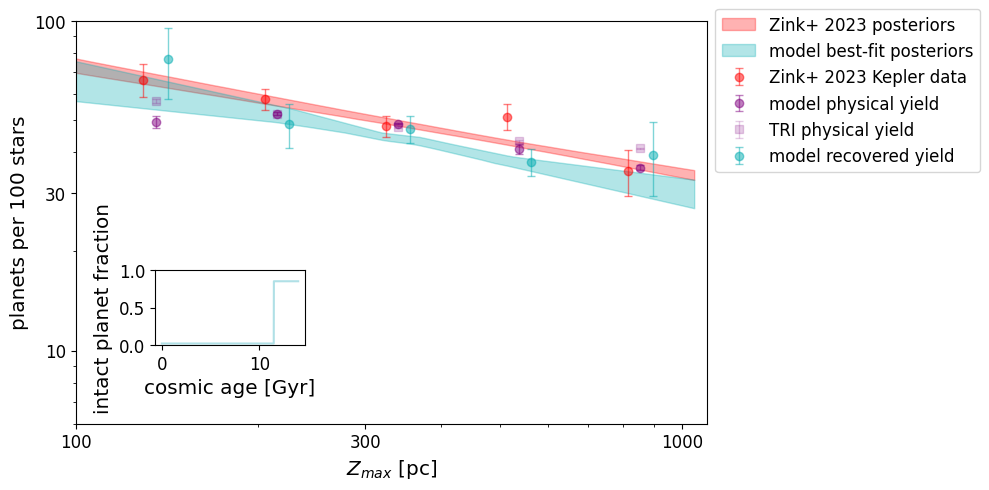

In [60]:
### set up plotting
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
left, bottom, width, height = [0.16, 0.3, 0.15, 0.15]
ax2 = fig.add_axes([left, bottom, width, height])

# zink+2023
ax1.errorbar(x=height_bin_midpoints, y=zink_kepler['occurrence'], yerr=(zink_kepler['occurrence_err1'], zink_kepler['occurrence_err2']), fmt='o', color='red', alpha=0.5, capsize=3, elinewidth=1, markeredgewidth=1, label='Zink+ 2023 Kepler data')
ax1.fill_between(z_max, yield_max, yield_min, color='red', alpha=0.3, label='Zink+ 2023 posteriors') #03acb1

# our simulated physical data
height_bin_midpoints1 = 0.5 * (np.logspace(2.02,3.02,6)[1:] + np.logspace(2.02,3.02,6)[:-1])
ax1.errorbar(x=height_bin_midpoints1, y=mean_physical_planet_occurrences_b20, yerr=yerr_b20, fmt='o', capsize=3, elinewidth=1, markeredgewidth=1, color='purple', alpha=0.5, label='model physical yield')

# TRILEGAL simulated physical data
height_bin_midpoints1 = 0.5 * (np.logspace(2.02,3.02,6)[1:] + np.logspace(2.02,3.02,6)[:-1])
ax1.errorbar(x=height_bin_midpoints1, y=mean_physical_planet_occurrences_tri, yerr=yerr_tri, fmt='s', capsize=3, elinewidth=1, markeredgewidth=1, color='purple', alpha=0.2, label='TRI physical yield')

# our recovered data
height_bin_midpoints2 = 0.5 * (np.logspace(2.04,3.04,6)[1:] + np.logspace(2.04,3.04,6)[:-1])
ax1.errorbar(x=height_bin_midpoints2, y=mean_recovered_planet_occurrences_b20, yerr=yerr_recovered_b20, fmt='o', capsize=3, elinewidth=1, markeredgewidth=1, color='#03acb1', alpha=0.5, label='model recovered yield')

# plot our best fit posteriors
our_yield_max = []
our_yield_min = []
our_models = []
for j in range(len(inf_data.posterior.data_vars['occurrence'])):
    tau = 0.5 * (inf_data.posterior.data_vars['tau'].values[0][j] + inf_data.posterior.data_vars['tau'].values[1][j])
    occurrence = 0.5 * (inf_data.posterior.data_vars['occurrence'].values[0][j] + inf_data.posterior.data_vars['occurrence'].values[1][j])
    our_models.append(model(z_max, tau, occurrence))
for temp_list2 in zip_longest(*our_models):
    our_yield_max.append(np.percentile(temp_list2, 84)) # plus one sigma
    our_yield_min.append(np.percentile(temp_list2, 16)) # minus one sigma
ax1.fill_between(z_max, our_yield_max, our_yield_min, color='#03acb1', alpha=0.3, label='model best-fit posteriors') 

ax1.set_xlim([100, 1100]) # add buffer room 
ax1.set_ylim([6, 100])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax1.set_xticks(ticks=[100, 300, 1000])
ax1.set_yticks(ticks=[10, 30, 100])
ax1.set_xlabel(r"$Z_{max}$ [pc]")
ax1.set_ylabel("planets per 100 stars")
#ax1.set_title('f=%1.2f' % frac1 + ' if <=%i ' % threshold + 'Gyr; f=%1.2f' % frac2 + ' if >%i ' % threshold + 'Gyr') 
ax1.legend(loc='upper left', bbox_to_anchor=[1.0, 1.05])

# step model
x = np.linspace(0, 14, 1000)
y = np.where(x <= threshold, frac1, frac2)

# monotonic model
#b = frac1
#m = (frac2 - frac1)/(x[-1] - x[0])
#y = b + m * x

# piecewise model
#m = (frac2 - frac1)/(x[-1] - threshold)
#y = np.where(x < threshold, frac1, frac1 + m * (x-threshold))

ax2.plot(x, y, color='powderblue')
ax2.set_xlabel('cosmic age [Gyr]')
ax2.set_ylabel('intact planet fraction')
ax2.set_ylim([0,1])

fig.tight_layout()
plt.savefig(path+'plots/sarah/model_vs_zink_'+name+'.png', format='png', bbox_inches='tight')
plt.show()
